In [302]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
import joblib

from transform import classify_features
from datetime import datetime, timedelta


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_float32_matmul_precision('high')


import torch._dynamo
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

import ray
from ray import tune, train
from ray.tune import CLIReporter, Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.air import session
from ray.train import Checkpoint, get_checkpoint, RunConfig, report
from ray.tune.stopper import TrialPlateauStopper

from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin


In [303]:
ray.shutdown()  # Shutdown any existing Ray instances
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2025-02-17 12:27:08,634	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.20
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [304]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'


In [305]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        
        return torch.sqrt(self.mse(predictions, targets)+1e-6)

importing data

In [306]:
input_file = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\luz_transformed_data.csv'
data = pd.read_csv(input_file)
data = data.fillna(0)

In [ ]:
X = data.drop(columns=['GWAP']).values
y = data[['LWAP']].values

In [308]:
colpath = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\luz_Daily_Complete.csv' #get columns 
col = pd.read_csv(colpath).fillna(0)
minmaxcols, boxcoxcols, yeojohnsoncols = classify_features(col)

processing data into splits

In [309]:
train_size = int(0.6 * len(X))  
val_size = int(0.20 * len(X))   
test_size = len(X) - train_size - val_size  

train_data = X[:train_size]
train_labels = y[:train_size]

val_data = X[train_size:train_size + val_size]
val_labels = y[train_size:train_size + val_size]

test_data = X[train_size + val_size:]
test_labels = y[train_size + val_size:]
seq_len=7
batch_size=64

In [310]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

custom lstm

In [311]:
class LSTMCustomCell(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn):
        super(LSTMCustomCell, self).__init__()
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        # Combine all gate matrices into one large matrix for efficiency
        self.W_ih = nn.Linear(input_size, 4 * hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
    def forward(self, x, hidden):
        h, c = hidden
        
        # Optimized matrix multiplication and bias addition
        gates = self.W_ih(x) + self.W_hh(h) + self.bias
        
        # Split into 4 gate vectors
        i_gate, f_gate, o_gate, g_gate = torch.chunk(gates, 4, dim=1)
        
        # Sigmoid activations for gates
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        
        # Apply the custom activation function for the cell gate
        g_gate = self.activation_fn(g_gate)
        
        # Compute the new cell state
        c_next = f_gate * c + i_gate * g_gate
        
        # Compute the new hidden state using the custom activation function
        h_next = o_gate * self.activation_fn(c_next)
        
        return h_next, c_next

In [312]:
class LSTMCustom(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, num_layers=1, activation_fn=torch.tanh, batch_first=False):
        super(LSTMCustom, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation_fn = activation_fn
        self.batch_first = batch_first
        self.dropout = dropout
        # Create a list of LSTM cells
        self.cells = nn.ModuleList([LSTMCustomCell(input_size if i == 0 else hidden_size, hidden_size, activation_fn) for i in range(num_layers)])
        self.dropout_layer = nn.Dropout(dropout) if dropout > 0.0 else None
    def forward(self, x, hidden=None):
        # Determine the correct input shape
        if self.batch_first:
            batch_size, seq_len, _ = x.size()
            x = x.transpose(0, 1)  # Convert to (seq_len, batch_size, input_size) for processing
        else:
            seq_len, batch_size, _ = x.size()
        
        if hidden is None:
            # Initialize hidden and cell states with zeros
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        else:
            h, c = hidden
        
        outputs = []
        
        # Iterate over each time step
        for t in range(seq_len):
            x_t = x[t, :, :]  # Input at time step t
            for i, cell in enumerate(self.cells):

                h[i], c[i] = cell(x_t, (h[i], c[i]))
                x_t = h[i]  # Pass hidden state to the next layer
                if self.dropout_layer and i < self.num_layers - 1:
                    x_t = self.dropout_layer(x_t)
            outputs.append(h[-1].unsqueeze(0))  # Collect output from the last layer
        
        # Stack the outputs across time steps
        outputs = torch.cat(outputs, dim=0)
        
        # Convert output back to (batch_size, seq_len, hidden_size) if batch_first is True
        if self.batch_first:
            outputs = outputs.transpose(0, 1)
        
        # Return outputs and the last hidden and cell states
        return outputs, (torch.stack(h), torch.stack(c))

lstm
edit here for what cell to use, and other layers

In [313]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,dropout,activation_fn,activation_fn1, norm_layer_type):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        lstm_dropout = dropout if num_layers > 1 else 0
        # LSTM layer
        #self.lstm = LSTMCustom(input_size, hidden_size, lstm_dropout, num_layers, activation_fn, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        self.dropout = nn.Dropout(dropout)

        # Additional fully connected layers with batch normalization
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)

        # Final output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    
        self.activation_fn = activation_fn
        self.activation_fn1 = activation_fn1
        self.norm_layer_type = norm_layer_type
    def forward(self, x):
        # Forward propagate LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Get last time step's output

        # Pass through fully connected layers with activation and batch normalization
        out = self.fc1(out)
        if self.norm_layer_type == 'batch_norm':
            out = self.batch_norm1(out)  # Batch normalization
        elif self.norm_layer_type == 'layer_norm':
            out = self.layer_norm1(out)
        out = self.activation_fn(out)  # Apply chosen activation function
        out = self.dropout(out)  # Apply dropout after activation
        
        
        # Final output layer with sigmoid
        out = self.fc_out(out)
        out = self.activation_fn1(out)

        return out

initial hyperparams

In [314]:
input_size = train_data.shape[1]  # Number of features
hidden_size = 128
output_size = train_labels.shape[1]  # Number of output features
num_layers = 2
activation_fn = torch.relu
dropout=0.1
epoch=100
# Define loss function and optimizer
train_criterion = nn.MSELoss()  # Use MSE loss for regression tasks
test_criterion = nn.L1Loss()
#test_criterion = RMSELoss()



training model

In [315]:
def train_model(model, dataloader, device, optimizer, lambda_reg, criterion):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += lambda_reg * l1_norm
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    return total_loss / total_samples if total_samples > 0 else 0.0

eval

In [316]:
@torch.no_grad()
def evaluate(model, dataloader, device, criterion):
    
    model.eval()
    total_loss = 0.0  # Initialize total loss
    total_samples = 0  # Initialize total sample count to 0

    for i, (inputs, target) in enumerate(dataloader):
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass
        outputs = model(inputs)

        predictions = outputs.to(device)

        loss = criterion(predictions, target)

        # Accumulate the loss and sample count
        total_loss += loss.item() * inputs.size(0)  # Total loss for the batch
        total_samples += inputs.size(0)  # Number of samples in the current batch


    return total_loss / total_samples if total_samples > 0 else 0.0  # Avoid division by zero


dataloader

In [317]:
def load_data():
    train_dataset = TimeSeriesDataset(train_data, train_labels, seq_len)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

    val_dataset = TimeSeriesDataset(val_data, val_labels, seq_len)    
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False) 
    
    return train_dataloader, val_dataloader

trainable lstm (the one for ray)

In [318]:
def raytrain(config,epoch):
    
    def set_seed(seed):
    
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

    set_seed(config["seed"])
    
    activation_fn_mapping = {
        "tanh": torch.tanh,
        "relu": F.relu,
        "identity": nn.Identity(),
        "sigmoid": torch.sigmoid
    }
    lambda_reg=config["lambda_reg"]
    norm_layer_type = config["norm_layer_type"]
    activation_fn = activation_fn_mapping[config["activation_fn"]]
    activation_fn1 = activation_fn_mapping[config["activation_fn1"]]
    model = LSTMModel(input_size, config["hidden_size"], output_size, config["num_layers"],config["dropout"],activation_fn=activation_fn,activation_fn1=activation_fn1, norm_layer_type=norm_layer_type).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  config["factor"],config["patience"])
    
    train_dataset = TimeSeriesDataset(train_data, train_labels, seq_len=config["seq_len"])
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    val_dataset = TimeSeriesDataset(val_data, val_labels, seq_len=config["seq_len"])    
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False) 
    for e in range(epoch):  # Replace with your actual number of epochs
        train_model(model, train_dataloader, device, optimizer, lambda_reg,train_criterion)
        val_loss = evaluate(model, val_dataloader, device, test_criterion)
        scheduler.step(val_loss)

        train.report(
            {
                "loss": val_loss
            }  
        )


inverse transform

In [319]:
minmax_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\box-cox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\yeo-johnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\box-cox_pipeliney.pkl')

In [ ]:
reordered_data = data[minmaxcols + boxcoxcols + yeojohnsoncols]
untransformed_data = pd.DataFrame(columns=minmaxcols + boxcoxcols + yeojohnsoncols)

if minmaxcols:
    untransformed_data[minmaxcols] = minmax_fit_loaded.inverse_transform(reordered_data[minmaxcols])

if boxcoxcols:
    untransformed_data[boxcoxcols] = boxcox_fit_loaded.inverse_transform(reordered_data[boxcoxcols].values)

if yeojohnsoncols:
    untransformed_data[yeojohnsoncols] = yeojohnson_fit_loaded.inverse_transform(reordered_data[yeojohnsoncols].values)

X_u = untransformed_data.copy().values
y_u = untransformed_data[['LWAP']].values

d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [321]:
u_train_data = X_u[:train_size]
u_train_labels = y_u[:train_size]

u_val_data = X_u[train_size:train_size + val_size]
u_val_labels = y_u[train_size:train_size + val_size]

u_test_data = X_u[train_size + val_size:]
u_test_labels = y_u[train_size + val_size:]

test dataloader

In [322]:
def load_test(batch_size,seq_len):
    test_dataset = TimeSeriesDataset(test_data, u_test_labels, seq_len)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    return test_dataloader

In [ ]:
@torch.no_grad()
def test_best_model(optimized_model,batch_size,seq_len):
    
    test_loader = load_test(batch_size,seq_len) 
    optimized_model.eval()

    wap_loss = 0.0
    total_samples = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            outputs = optimized_model(inputs)
            predictions = outputs.to(device)
            
            all_predictions.append(predictions)
            all_targets.append(target)

    # Concatenate all predictions and targets for inverse transformation
    all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()  
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy() 
    
    # Apply inverse transformations to predictions and targets
    all_predictions_2d = np.zeros((all_predictions.shape[0], 2))  
    all_predictions_2d[:, 1] = all_predictions[:, 0]  # Fill only the first column with predictions (LWAP)
    #all_predictions_2d[:, 0] = all_predictions[:, 0]  # Fill only the first column with predictions (GWAP)
    
    #all_predictions_inverse = boxcoxy_fit_loaded.inverse_transform(all_predictions_2d)[:, 0] # GWAP
    all_predictions_inverse = boxcoxy_fit_loaded.inverse_transform(all_predictions_2d)[:, 1] # LWAP

  
    predictions_output = all_predictions_inverse
    targets_output = all_targets.squeeze()

    
    wap_untransformed_loss = test_criterion(
        torch.tensor(predictions_output, dtype=torch.float32).to(device),
        torch.tensor(targets_output, dtype=torch.float32).to(device)
    )

    # Accumulate the losses
    wap_loss += wap_untransformed_loss.item() * predictions_output.shape[0]
    total_samples += predictions_output.shape[0]
  
    # Calculate and return the average loss
    average_wap_loss = wap_loss / total_samples if total_samples > 0 else 0.0
    print("Average GWAP Loss:", average_wap_loss)

    return average_wap_loss, all_predictions_inverse


plot

In [ ]:
def plot_predictions(all_predictions_inverse,island):
    
    output_folder =  os.path.join(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY', island)
    
    #actual_gwap = np.array(col['GWAP'])  # Convert to NumPy array
    actual_lwap = np.array(col['LWAP'])  # Convert to NumPy array

    
    if(island=="Mindanao"):
        full_date_range = pd.date_range(start="2023-01-01", end="2023-12-31", freq="D").to_numpy()
    else:
        full_date_range = pd.date_range(start="2022-01-01", end="2023-12-31", freq="D").to_numpy()

    
    test_data_points = all_predictions_inverse.shape[0]
    test_start_date = datetime(2023, 12, 31) - timedelta(days=test_data_points - 1)
    test_date_range = pd.date_range(start=test_start_date, periods=test_data_points, freq="D").to_numpy()


    
    wap_predictions = all_predictions_inverse
    

    # Plotting

    plt.figure(figsize=(12, 6))

    #plt.plot(full_date_range, actual_gwap, label='GWAP Actual (Full Data)', color='blue')
    plt.plot(full_date_range, actual_lwap, label='LWAP Actual (Full Data)', color='green')
    plt.plot(test_date_range, wap_predictions, label='GWAP Prediction', color='red')

    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{island} LWAP Predictions vs Actual Values')
    plt.legend()
    plt.savefig(os.path.join(output_folder, f'{island}_preds.png'))
    plt.show()

main function
(it uses ray to optimize then uses test_best_model to run 10 tiems of the most optimized)

In [ ]:
def main(epoch,island,trials):
    set_seed(1)
    search_space = {
        "hidden_size": tune.choice([16,32, 64, 128, 256, 512]),
        "lr": tune.loguniform(1e-5, 1e-2),
        "weight_decay": tune.loguniform(1e-5, 1e-2),
        "dropout": tune.uniform(0.0, 0.5),
        "activation_fn": tune.choice(["tanh","relu"]),
        "activation_fn1": tune.choice(["sigmoid","identity"]),
        "seed": 1,
        "num_layers": tune.choice([1,2, 3,4]),
        "patience": tune.choice([5, 10, 20]),
        "factor": tune.uniform(0.1, 0.5),
        "seq_len":tune.choice([3,5,7,9]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "norm_layer_type": tune.choice(['batch_norm','layer_norm','none']),
        "lambda_reg": tune.loguniform(1e-5, 1e-1)
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=50,
        reduction_factor=2
    )
    plateau_stopper = TrialPlateauStopper(metric="val_loss",mode="min")

    reporter = CLIReporter(
        metric_columns=["loss", "training_iteration"]
    )

    def trial_dirname_creator(trial):
        return f"trial_{trial.trial_id}"

    trainable_with_params = tune.with_parameters(raytrain, epoch=epoch)


    trainable_with_resources = tune.with_resources(trainable_with_params, resources={"cpu": 4, "gpu": 0.2})

    # Step 1: Hyperparameter tuning
    tuner = Tuner(
        trainable_with_resources,  
        param_space=search_space,
        tune_config=tune.TuneConfig(
            search_alg=OptunaSearch(metric="loss", mode="min"),
            num_samples=trials,
            scheduler=scheduler,
            trial_dirname_creator=trial_dirname_creator
        ),
        run_config=RunConfig(
            progress_reporter=reporter,
            verbose=1,
            stop=plateau_stopper
        )
    )
    
    # Run the tuner and collect the results
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))

    activation_fn_mapping = {
        "tanh": torch.tanh,
        "relu": F.relu,
        "identity": nn.Identity(),
        "sigmoid": torch.sigmoid
    }
    optimized_lambda_reg = best_result.config["lambda_reg"]
    optimized_activation_fn = activation_fn_mapping.get(best_result.config["activation_fn"])
    optimzed_activation_fn1 = activation_fn_mapping.get(best_result.config["activation_fn1"])
    optimized_norm_layer_type = best_result.config["norm_layer_type"]
    
    # Step 2: Training and testing with different seeds
    wap_loss = 0.0

    num_seeds = 10  # Total seeds to test
    train_dataset = TimeSeriesDataset(train_data, train_labels, best_result.config["seq_len"])
    train_dataloader = DataLoader(train_dataset, best_result.config["batch_size"], shuffle=False)

    val_dataset = TimeSeriesDataset(val_data, val_labels, best_result.config["seq_len"])    
    val_dataloader = DataLoader(val_dataset, best_result.config["batch_size"], shuffle=False) 
    all_pred_inverses = []
    all_train_losses = []
    all_val_losses = []
    for seed in range(1, num_seeds + 1):
        set_seed(seed)
        optimized_model = LSTMModel(
            input_size=input_size,
            hidden_size=best_result.config["hidden_size"],
            output_size=output_size,
            num_layers=best_result.config["num_layers"],
            dropout=best_result.config["dropout"],
            activation_fn=optimized_activation_fn,
            activation_fn1=optimzed_activation_fn1,
            norm_layer_type=optimized_norm_layer_type
        ).to(device)

        optimizer_op = optim.AdamW(
            optimized_model.parameters(),
            lr=best_result.config["lr"],
            weight_decay=best_result.config["weight_decay"]
        )
        scheduler_op = ReduceLROnPlateau(optimizer_op, 'min', factor=best_result.config["factor"], patience=best_result.config["patience"])

        train_losses = []
        val_losses = []

    # Train the model with the best configuration and the current seed
        for e in range(epoch):
            train_loss = train_model(optimized_model, train_dataloader, device, optimizer_op, optimized_lambda_reg, train_criterion)
            val_loss = evaluate(optimized_model, val_dataloader, device, test_criterion)
            scheduler_op.step(val_loss)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # Test the model using the trained optimized_model
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        wap_seed_loss, pred_inverse = test_best_model(optimized_model,best_result.config["batch_size"],best_result.config["seq_len"]) 
        wap_loss += wap_seed_loss

        all_pred_inverses.append(np.array(pred_inverse))

# At the end, you’ll have accumulated separate gwap and lwap losses across all seeds
    average_wap_loss = wap_loss / num_seeds
    print("Average LWAP test loss over {} runs: {:.4f}".format(num_seeds, average_wap_loss))

    stacked_predictions = np.stack(all_pred_inverses)
    avg_pred_inverse = np.mean(stacked_predictions, axis=0)  

# Plot the averaged predictions
    output_folder =  os.path.join(r'D:/School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY', island)
    plot_predictions(avg_pred_inverse,island)

    for i in range(num_seeds):
        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[i], label=f'Training Loss Seed {i+1}')
        plt.plot(all_val_losses[i], label=f'Validation Loss Seed {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(0, 0.5)
        plt.legend()
        plt.title(f'{island} Training and Validation Losses per Epoch for Seed {i+1}')
        plt.savefig(os.path.join(output_folder, f'{island} training_validation_loss_seed_{i+1}.png'))
        plt.show()
    return best_result.config, average_wap_loss


2025-02-17 12:27:11,698	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2025-02-17 12:27:11,708] A new study created in memory with name: optuna


== Status ==
Current time: 2025-02-17 12:27:11 (running for 00:00:00.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 100.000: None | Iter 50.000: None
Logical resource usage: 4.0/20 CPUs, 0.2/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2025-02-17_12-27-06_060019_24404/artifacts/2025-02-17_12-27-11/raytrain_2025-02-17_12-27-11/driver_artifacts
Number of trials: 1/500 (1 PENDING)


== Status ==
Current time: 2025-02-17 12:27:16 (running for 00:00:05.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 100.000: None | Iter 50.000: None
Logical resource usage: 8.0/20 CPUs, 0.4/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2025-02-17_12-27-06_060019_24404/artifacts/2025-02-17_12-27-11/raytrain_2025-02-17_12-27-11/driver_artifacts
Number of trials: 2/500 (1 PENDING, 1 RUNNING)


== Status ==
Current time: 2025-02-17 12:27:21 (running for 00:00:10.21)
Using AsyncHyperBand: num_

2025-02-17 12:53:42,807	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Paulo John Mercado/ray_results/raytrain_2025-02-17_12-27-11' in 0.3713s.
2025-02-17 12:53:42,828	INFO tune.py:1041 -- Total run time: 1591.13 seconds (1590.72 seconds for the tuning loop).


== Status ==
Current time: 2025-02-17 12:53:42 (running for 00:26:31.10)
Using AsyncHyperBand: num_stopped=500
Bracket: Iter 100.000: -0.10122256416038874 | Iter 50.000: -0.1232258528470993
Logical resource usage: 4.0/20 CPUs, 0.2/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2025-02-17_12-27-06_060019_24404/artifacts/2025-02-17_12-27-11/raytrain_2025-02-17_12-27-11/driver_artifacts
Number of trials: 500/500 (500 TERMINATED)


Best trial config: {'hidden_size': 16, 'lr': 0.005224482445191083, 'weight_decay': 5.362496349224092e-05, 'dropout': 0.19918690808173656, 'activation_fn': 'tanh', 'activation_fn1': 'identity', 'seed': 1, 'num_layers': 1, 'patience': 10, 'factor': 0.4924630888769119, 'seq_len': 3, 'batch_size': 256, 'norm_layer_type': 'batch_norm', 'lambda_reg': 0.005488599770799952}
Best trial final validation loss: 0.0842481479048729


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1545.1019287109375


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1349.244140625


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1460.7840576171875


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1620.5235595703125


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1409.918701171875


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1362.030517578125


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1301.6063232421875


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1446.4661865234375


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Average GWAP Loss: 1474.0999755859375
Average GWAP Loss: 1259.4248046875
Average GWAP test loss over 10 runs: 1422.9200


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


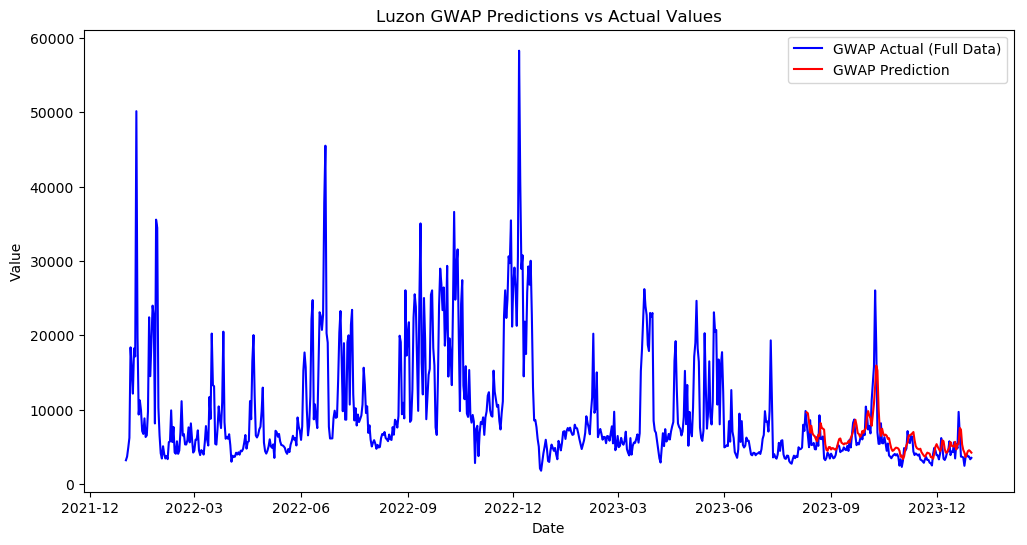

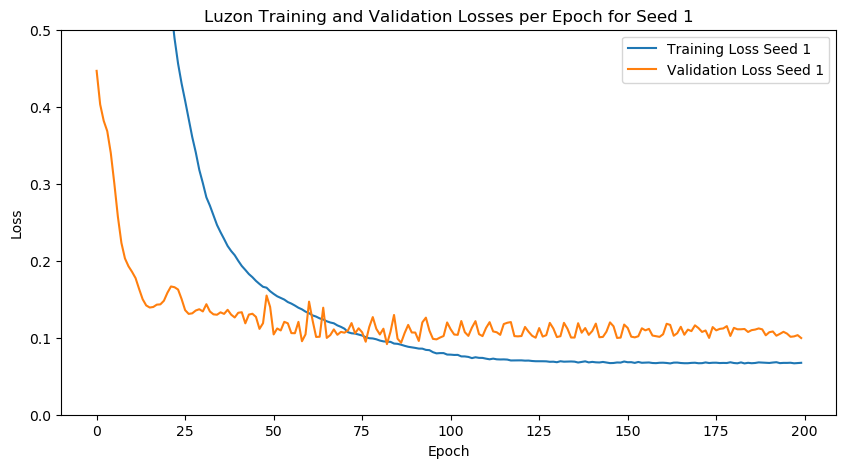

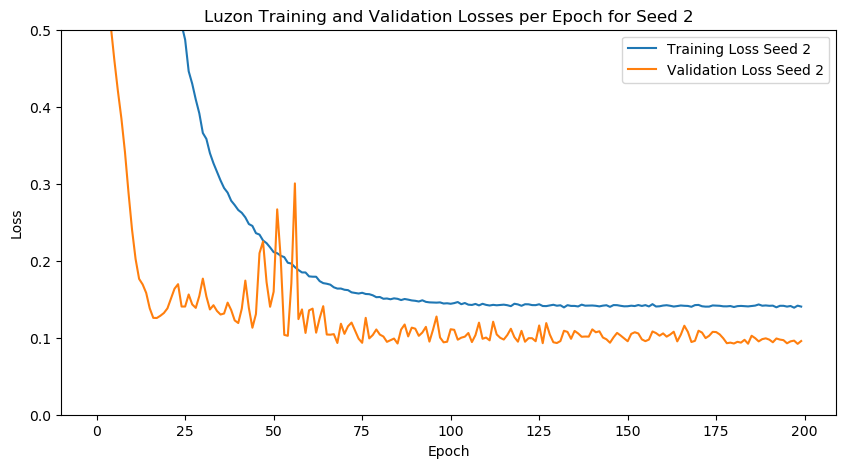

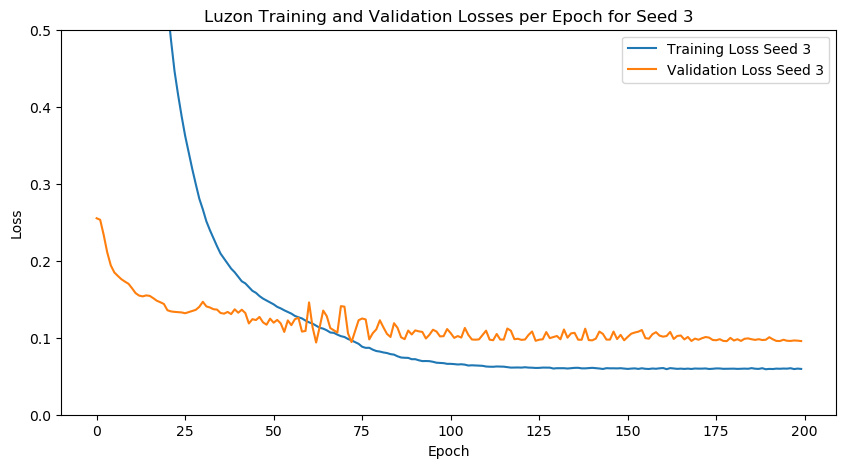

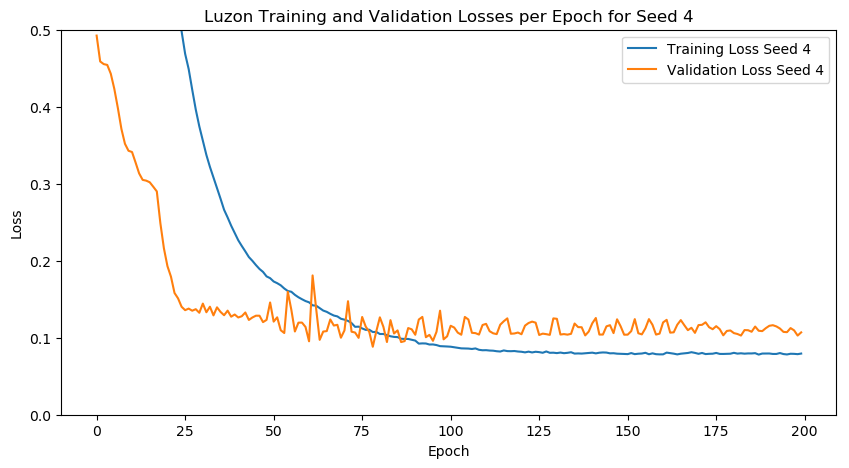

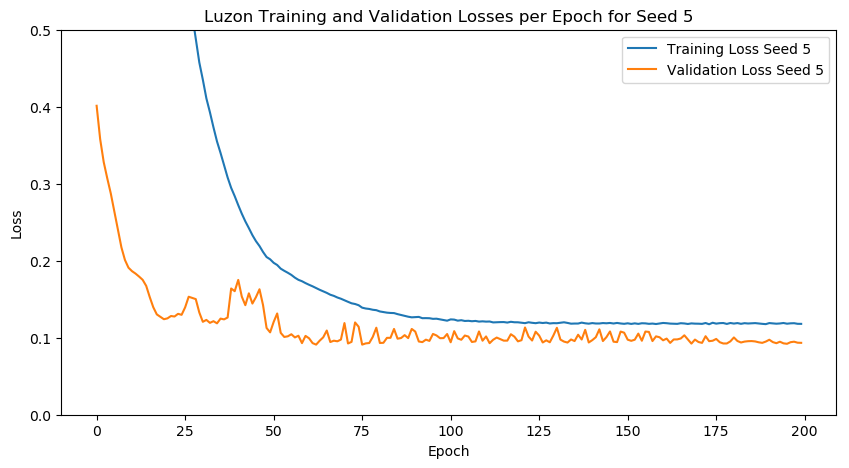

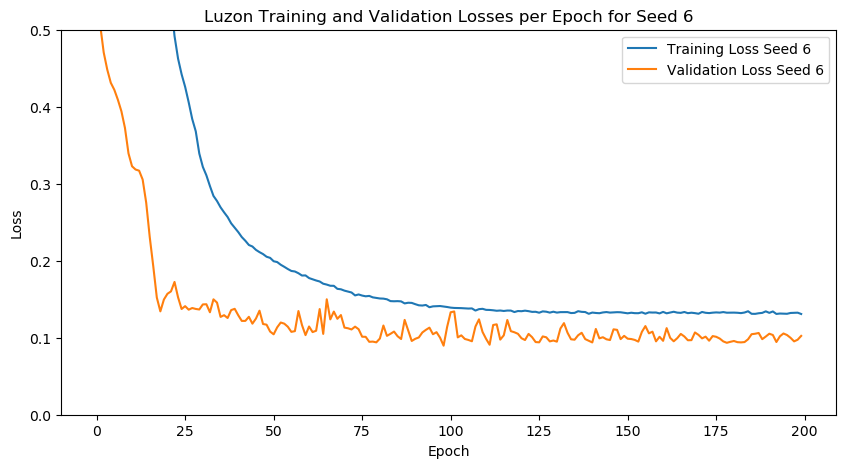

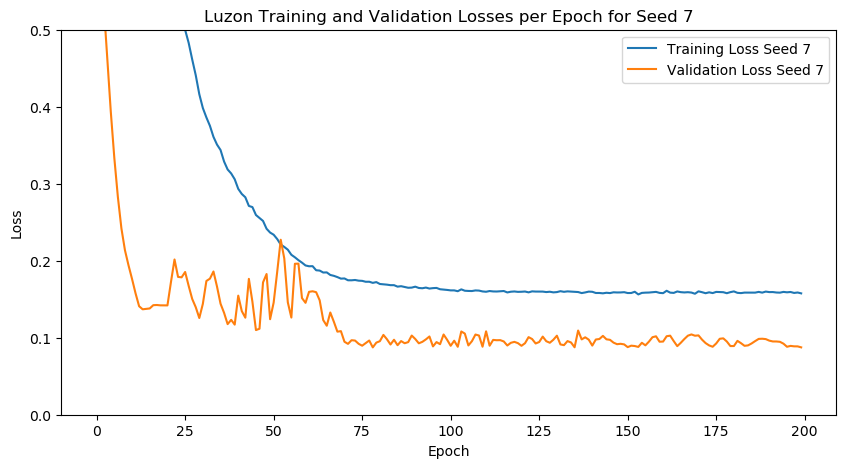

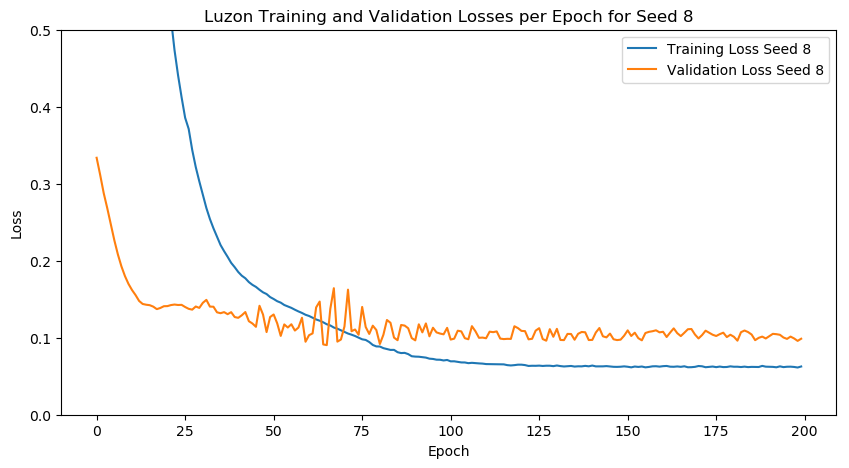

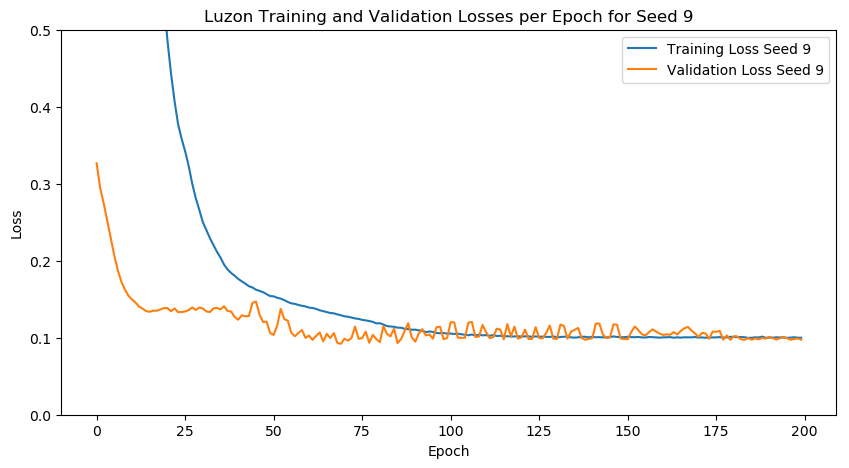

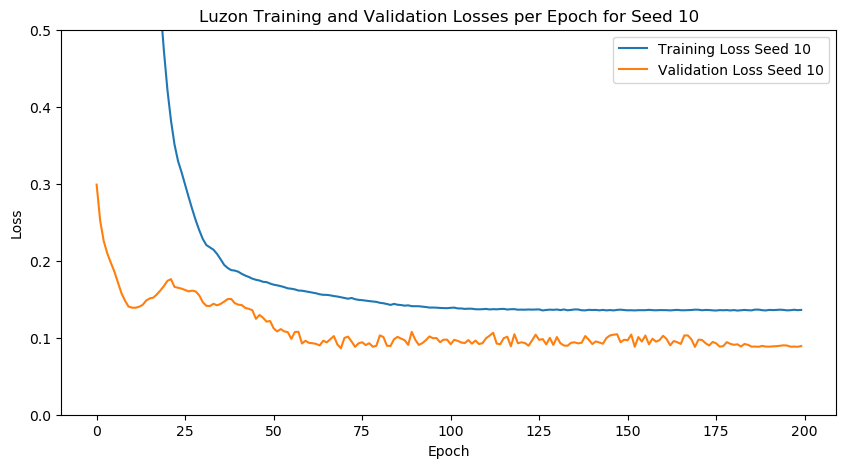

In [326]:
bestresult,wap_test_loss = main(200,"Luzon",500)

if i want to run with a specific hyperparam

In [327]:
def run(epoch,island):
    gwap_loss = 0.0
    lwap_loss = 0.0
    num_seeds = 10  # Total seeds to test
    all_pred_inverses = []
    all_train_losses = []
    all_val_losses = []
    batch_size=64
    seq_len=7
    train_dataset = TimeSeriesDataset(train_data, train_labels, seq_len=seq_len)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    val_dataset = TimeSeriesDataset(val_data, val_labels, seq_len=seq_len)    
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 
    for seed in range(1, num_seeds + 1):
        set_seed(seed)
        optimized_model = LSTMModel(
            input_size=input_size,
            hidden_size=64,
            output_size=output_size,
            num_layers=1,
            dropout=  0.19843489104284265,
            activation_fn=torch.tanh,
            activation_fn1=nn.Identity(),
            norm_layer_type="batch_norm"
        ).to(device)

        optimizer_op = optim.AdamW(
            optimized_model.parameters(),
            lr=  0.019182000337794873,
            weight_decay=0.0044017743051057755
        )
        scheduler_op = ReduceLROnPlateau(optimizer_op, 'min', factor= 0.2551149904658089, patience=10)

        train_losses = []
        val_losses = []

    # Train the model with the best configuration and the current seed
        for e in range(epoch):
            train_loss = train_model(optimized_model, train_dataloader, device, optimizer_op, train_criterion)
            val_loss = evaluate(optimized_model, val_dataloader, device, test_criterion)
            scheduler_op.step(val_loss)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # Test the model using the trained optimized_model
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        gwap_seed_loss,  pred_inverse = test_best_model(optimized_model,batch_size,seq_len)  # Modify this function to return gwap and lwap losses
        gwap_loss += gwap_seed_loss

        all_pred_inverses.append(np.array(pred_inverse))

# At the end, you’ll have accumulated separate gwap and lwap losses across all seeds
    average_gwap_loss = gwap_loss / num_seeds
    average_lwap_loss = lwap_loss / num_seeds

    # Print the average test loss for each output
    print("Average GWAP test loss over {} runs: {:.4f}".format(num_seeds, average_gwap_loss))
    print("Average LWAP test loss over {} runs: {:.4f}".format(num_seeds, average_lwap_loss))
    stacked_predictions = np.stack(all_pred_inverses)
    avg_pred_inverse = np.mean(stacked_predictions, axis=0)  # Average across seeds
    all_losses = np.concatenate(all_train_losses + all_val_losses)
    
    y_max = all_losses.max()
# Plot the averaged predictions
    output_folder =  os.path.join(r'D:/School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY', island)
    plot_predictions(avg_pred_inverse,island)
    for i in range(num_seeds):
        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[i], label=f'Training Loss Seed {i+1}')
        plt.plot(all_val_losses[i], label=f'Validation Loss Seed {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(0, 0.5)
        plt.legend()
        plt.title(f'{island} Training and Validation Losses per Epoch for Seed {i+1}')
        plt.savefig(os.path.join(output_folder, f'{island} training_validation_loss_seed_{i+1}.png'))
        plt.show()
    

In [328]:
#run(200,"Mindanao")